In [1]:
#Import relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf,plot_acf
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Import functions notebook and load data set here
import sys
sys.path.append("../")
from time_series_functions import *

In [3]:
df=pd.read_csv('../zillow_data.csv')

In [4]:
df=melt_data2(df)

In [5]:
df.set_index('time',inplace=True)

In [6]:
# Rename RegionName to be Zipcode
df=df.rename({'RegionName':'Zipcode'},axis='columns')

In [7]:
#drop no longer relevant columns
df.drop(['RegionID','SizeRank','City','CountyName'],axis=1,inplace=True)

In [8]:
Arizona_df= df[(df['State'] == 'AZ')]

In [9]:
Arizona_df

,Zipcode,State,Metro,value
time,,,,
1996-04-01,85032,AZ,Phoenix,95400.0
1996-04-01,85710,AZ,Tucson,94600.0
1996-04-01,85225,AZ,Phoenix,101200.0
1996-04-01,85308,AZ,Phoenix,124800.0
1996-04-01,85281,AZ,Phoenix,81200.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [10]:
Arizona_recent_yrs=Arizona_df['2009-01-01':'2018-04-01']

In [11]:
Arizona_recent_yrs

,Zipcode,State,Metro,value
time,,,,
2009-01-01,85032,AZ,Phoenix,190200.0
2009-01-01,85710,AZ,Tucson,171100.0
2009-01-01,85225,AZ,Phoenix,179900.0
2009-01-01,85308,AZ,Phoenix,212000.0
2009-01-01,85281,AZ,Phoenix,181300.0
...,...,...,...,...
2018-04-01,86332,AZ,Prescott,172500.0
2018-04-01,85645,AZ,Tucson,152300.0
2018-04-01,85928,AZ,Show Low,225100.0


In [12]:
Phoenix_data = Arizona_recent_yrs[(Arizona_recent_yrs['Metro'] == 'Phoenix')]

In [13]:
Phoenix_data
Phoenix_data=Phoenix_data.drop(['State','Metro'],axis=1)

In [14]:
top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
(Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                             (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]

In [15]:
def get_zip(zipcode):
    top_10_zips_phx=Phoenix_data[(Phoenix_data['Zipcode'] == 85253)|(Phoenix_data['Zipcode'] == 85262)|
    (Phoenix_data['Zipcode'] == 85377)| (Phoenix_data['Zipcode'] == 85255)|(Phoenix_data['Zipcode'] == 85266)|
                             (Phoenix_data['Zipcode'] == 85259)|(Phoenix_data['Zipcode'] == 85258)|
                            (Phoenix_data['Zipcode'] == 85018)|(Phoenix_data['Zipcode'] == 85263)|
                             (Phoenix_data['Zipcode'] == 85054)]
    zip_zipcode=top_10_zips_phx[top_10_zips_phx['Zipcode']==zipcode]
    #zip_zipcode.drop(['index'],axis=1,inplace=True)
    zip_zipcode.reset_index(inplace=True)
    
    # shift by one period (month)
    resampled_shift_1 = zip_zipcode[['value']].shift(1)
    resampled_shift_1.bfill(inplace=True)

#reset the indexes to perform calculation of growth
    top_10_zips_phx = zip_zipcode.reset_index()
    resampled_shift_1 = resampled_shift_1.reset_index()

#Growth Calculation
    zip_zipcode['growth'] = (zip_zipcode['value'] - resampled_shift_1['value'])/(resampled_shift_1['value'])
    zip_zipcode['growth']= abs(zip_zipcode['growth'])
#set the index back to zipcode and time multi-index
    zip_zipcode.set_index(['time'],inplace=True)
    
    zip_zipcode.drop('Zipcode',axis=1,inplace=True)
    data= top_10_zips_phx
    print(f'The stationarity check for zipcode {zipcode} before adjustments:{stationarity_check(zip_zipcode.growth)}')
    
    #Original Plot
    fig, ax = plt.subplots()
    ax.plot(zip_zipcode.growth)
    ax.set_title(f"Original Zipcode Plot for {zipcode}");
    
    #log values and dropna
    log_zipcode= abs(np.log(zip_zipcode.growth))
    log_zipcode.dropna(inplace=True)
    
    # get roll mean and subtract
    roll_mean = log_zipcode.rolling(window=7,center=False).mean()
    data_minus_roll_mean = log_zipcode-roll_mean
    
    #Drop missing values
    data_minus_roll_mean.dropna(inplace=True)
    return data_minus_roll_mean
    #Plot the data minus roll mean
    #data_minus_roll_mean.plot(figsize=(10,6));
    fig, ax = plt.subplots()
    ax.plot(data_minus_roll_mean)
    ax.set_title(f"Final Zipcode Plot for {zipcode}");

    print(f'The stationarity check for zipcode {zipcode}, after adjustments:{stationarity_check(data_minus_roll_mean)}')
    


Results of Dickey-Fuller Test: 

Test Statistic                  -2.126796
p-value                          0.233877
#Lags Used                       8.000000
Number of Observations Used    103.000000
Critical Value (1%)             -3.495493
Critical Value (5%)             -2.890037
Critical Value (10%)            -2.581971
dtype: float64
The stationarity check for zipcode 85259 before adjustments:None


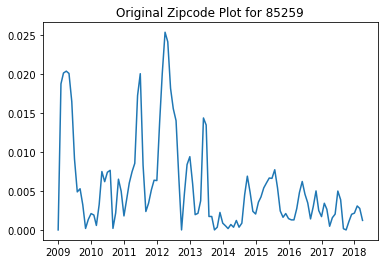

In [81]:
minus_roll_mean=get_zip(85259)

In [60]:
minus_roll_mean=minus_roll_mean.diff()

In [88]:
minus_roll_mean=minus_roll_mean.diff().dropna()

In [89]:
# find the index which allows us to split off 20% of the data
cutoff = round(minus_roll_mean.shape[0]*0.8)
cutoff

66

In [90]:
# Define train and test sets according to the index found above
train = minus_roll_mean[:cutoff]

test = minus_roll_mean[cutoff:]

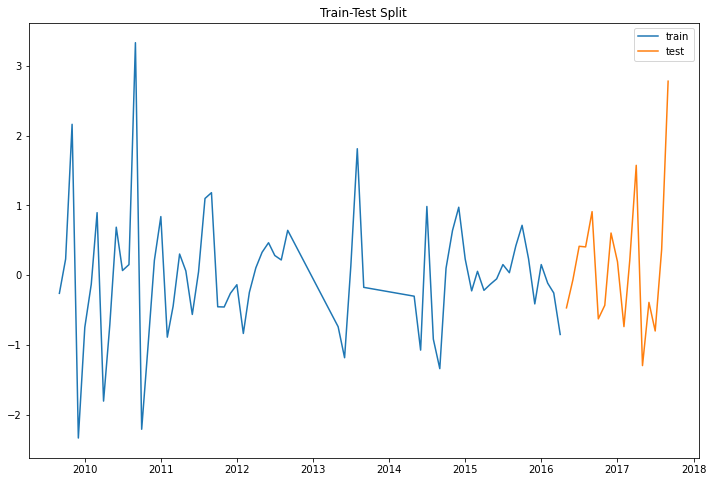

In [91]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [92]:
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(train_ind, val_ind)

[ 0  1  2  3  4  5  6  7  8  9 10] [11 12 13 14 15 16 17 18 19 20 21]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21] [22 23 24 25 26 27 28 29 30 31 32]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32] [33 34 35 36 37 38 39 40 41 42 43]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43] [44 45 46 47 48 49 50 51 52 53 54]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54] [55 56 57 58 59 60 61 62 63 64 65]


In [93]:
# we can perform this with the shift operator
# The prediction for the next day is the original series shifted to the future by one day.
baseline = train.shift(1)
baseline

time
2009-09-01         NaN
2009-10-01   -0.259932
2009-11-01    0.232011
2009-12-01    2.162337
2010-01-01   -2.333660
                ...   
2015-12-01    0.236000
2016-01-01   -0.411452
2016-02-01    0.152094
2016-03-01   -0.114580
2016-04-01   -0.254806
Name: growth, Length: 66, dtype: float64

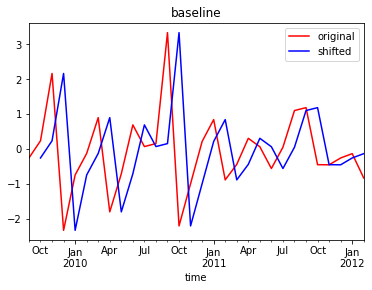

In [94]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
baseline[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('baseline')
ax.legend();

In [95]:
np.sqrt(mean_squared_error(train[1:], baseline.dropna()))

1.3421577015591073

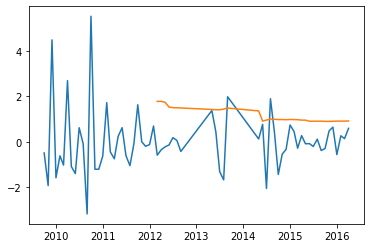

In [96]:
fig, ax = plt.subplots()
residuals = baseline[1:] - train[1:]
ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(30).std());

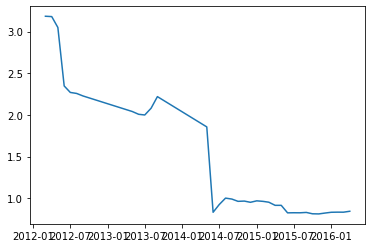

In [97]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

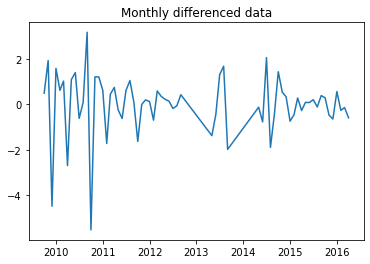

In [98]:
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Monthly differenced data');

In [99]:
p_val = adfuller(train.diff()[1:])[1]
print(f"The p-value associated with the Dickey-Fuller statistical test is {p_val},")
if p_val < 0.05:
    print(" so we can safely assume that the differenced data is stationary.")
else:
    print(" so we cannot reject the null hypothesis that the differenced data is \
not stationary.")

The p-value associated with the Dickey-Fuller statistical test is 1.414498752130111e-07,
 so we can safely assume that the differenced data is stationary.


In [100]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

time
2009-09-01    0.000000
2009-10-01   -0.259932
2009-11-01    0.033623
2009-12-01    1.383885
2010-01-01   -0.520535
                ...   
2015-12-01    0.429113
2016-01-01   -0.150350
2016-02-01   -0.075170
2016-03-01   -0.007037
2016-04-01   -0.198256
Name: predicted_mean, Length: 66, dtype: float64

In [101]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   66
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -105.518
Date:                Tue, 04 Jan 2022   AIC                            215.035
Time:                        17:57:09   BIC                            219.384
Sample:                             0   HQIC                           216.751
                                 - 66                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4033      0.115     -3.500      0.000      -0.629      -0.177
sigma2         1.5009      0.251      5.976      0.000       1.009       1.993
===================================================================================
Ljung-Box (L1) (Q):                   2.31   Jarque-Bera (JB):                17.54
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               0.17   Skew:                            -0.61
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   66
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -111.359
Date:                Tue, 04 Jan 2022   AIC                            224.718
Time:                        17:57:10   BIC                            226.893
Sample:                             0   HQIC                           225.576
                                 - 66                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         1.8014      0.173     10.428      0.000       1.463       2.140
===================================================================================
Ljung-Box (L1) (Q):                  11.30   Jarque-Bera (JB):                82.40
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.15   Skew:                            -1.48
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [103]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 224.71822003794531
AR(1, 1, 0) AIC: 215.0354968309761


In [104]:
y_hat_ar1 = ar_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

1.216478336718105

In [105]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

1.3323352645420183

In [106]:
train.index

DatetimeIndex(['2009-09-01', '2009-10-01', '2009-11-01', '2009-12-01',
               '2010-01-01', '2010-02-01', '2010-03-01', '2010-04-01',
               '2010-05-01', '2010-06-01', '2010-07-01', '2010-08-01',
               '2010-09-01', '2010-10-01', '2010-11-01', '2010-12-01',
               '2011-01-01', '2011-02-01', '2011-03-01', '2011-04-01',
               '2011-05-01', '2011-06-01', '2011-07-01', '2011-08-01',
               '2011-09-01', '2011-10-01', '2011-11-01', '2011-12-01',
               '2012-01-01', '2012-02-01', '2012-03-01', '2012-04-01',
               '2012-05-01', '2012-06-01', '2012-07-01', '2012-08-01',
               '2012-09-01', '2013-05-01', '2013-06-01', '2013-07-01',
               '2013-08-01', '2013-09-01', '2014-05-01', '2014-06-01',
               '2014-07-01', '2014-08-01', '2014-09-01', '2014-10-01',
               '2014-11-01', '2014-12-01', '2015-01-01', '2015-02-01',
               '2015-03-01', '2015-04-01', '2015-05-01', '2015-06-01',
      

In [107]:
train_with_ind = train.reset_index()

In [108]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(1, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.3573522236160953
0.7218148983462515
0.8521255010929002
1.0888672153326322
0.43062989697810045


In [109]:
ar_1.arparams

array([-0.40327536])

In [110]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[-0.4086346]


In [111]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

time
2009-09-01    0.000000
2009-10-01   -0.259932
2009-11-01    0.030390
2009-12-01    0.786139
2010-01-01   -0.530957
                ...   
2015-12-01    0.387380
2016-01-01    0.193254
2016-02-01    0.111035
2016-03-01   -0.212413
2016-04-01   -0.049531
Name: predicted_mean, Length: 66, dtype: float64

In [112]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

224.71822003794531
215.0354968309761
202.21360103713593


In [113]:
y_hat_ar1 = ar_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

1.0885145169665527

In [114]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 0)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.275946620269159
0.6485753435977597
0.8332091282394872
0.930293740076074
0.4185951138607878


### Moving Avg

In [115]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

time
2009-09-01   -0.018083
2009-10-01    0.053233
2009-11-01   -0.075821
2009-12-01   -0.747535
2010-01-01    0.499359
                ...   
2015-12-01   -0.195354
2016-01-01    0.052423
2016-02-01   -0.050603
2016-03-01    0.002791
2016-04-01    0.065963
Name: predicted_mean, Length: 66, dtype: float64

In [116]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                 growth   No. Observations:                   66
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 -85.319
Date:                Tue, 04 Jan 2022   AIC                            176.637
Time:                        17:57:17   BIC                            183.206
Sample:                             0   HQIC                           179.233
                                 - 66                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0181      0.083     -0.218      0.828      -0.181       0.145
ma.L1         -0.3263      0.120     -2.723      0.006      -0.561      -0.091
sigma2         0.7756      0.100      7.720      0.000       0.579       0.972
===================================================================================
Ljung-Box (L1) (Q):                   0.72   Jarque-Bera (JB):                25.97
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):               0.26   Skew:                             0.92
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [117]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()

print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

224.71822003794531
215.0354968309761
202.21360103713593
179.55363100008432


In [118]:
y_hat_ar1 = ma_1.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.9535789884280587

In [119]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 1)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.3285256326068566
0.6150929842545645
0.8155968535545254
0.6855619999249879
0.4014249349818022


In [120]:
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

time
2009-09-01    0.000000
2009-10-01   -0.259932
2009-11-01   -0.063051
2009-12-01    0.334717
2010-01-01    0.586406
                ...   
2015-12-01   -0.125068
2016-01-01    0.069887
2016-02-01   -0.026008
2016-03-01    0.017861
2016-04-01    0.063170
Name: predicted_mean, Length: 66, dtype: float64

In [121]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

224.71822003794531
215.0354968309761
202.21360103713593
179.55363100008432
179.92498490014614


In [122]:
y_hat_ar1 = ma_2.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_ar1))

0.9439248771677464

In [123]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(0, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.3478524025647212
0.613298432136253
0.825891113097901
0.6387605585845891
0.40191627975706457


### ARMA

In [124]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [125]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

224.71822003794531
215.0354968309761
202.21360103713593
179.55363100008432
179.92498490014614
171.9468892595681


In [126]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [127]:
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

1.3323352645420183
1.216478336718105
1.0885145169665527
0.9535789884280587
0.9439248771677464
0.900523068937077


In [128]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog=train_with_ind.iloc[train_ind, -1], order=(2, 1, 2)).fit()
    preds = ar.predict(typ='levels', start=val_ind[0], end=val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

1.641295886927683
0.5944057644427237
0.8153034393063568
0.738684037565508
0.39920547238692816


In [129]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [130]:
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'